In [3]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math

In [4]:
import sys
sys.path.append('../../')
from algos.agents.dqn_agent import DQNAgent
from algos.models.dqn_cnn import DQNCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

In [5]:
env = gym.make('SpaceInvaders-v0',render_mode='human')
env.seed(0)

D:\python\lib\site-packages\gym\envs\registration.py:568: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


(2968811710, 3677149159)

In [6]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


The size of frame is:  (210, 160, 3)
No. of Actions:  6


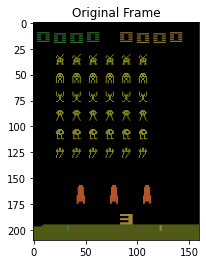

In [7]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [8]:
def random_play():
    score = 0
    env.reset()
    while True:
        #env.render(mode='human')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  240.0


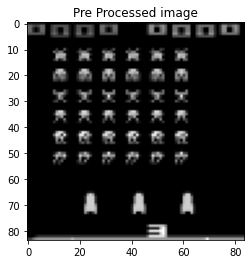

In [9]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

In [10]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

In [11]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

agent = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)

In [12]:
# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    #env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

In [13]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

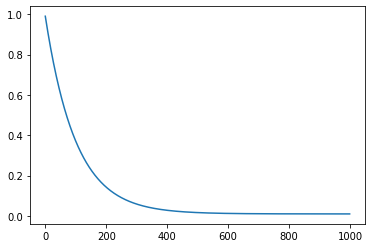

In [14]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [15]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    
    return scores

Episode 100	Average Score: 162.50


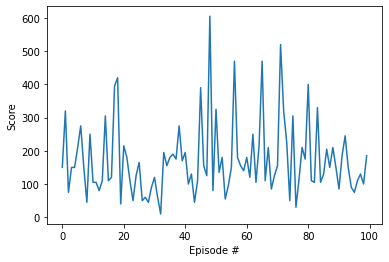

In [16]:
scores = train(100)


In [17]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

You Final score is: 225.0
